In [10]:
# import / environment setup
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)

pd.set_option("display.max_columns", None)

In [11]:
# data load
df = pd.read_csv("../data/diabetic_data.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [12]:
# target definition
df["readmit_30"] = (df["readmitted"] == "<30").astype(int)
df["readmit_30"].value_counts(normalize=True)

readmit_30
0    0.888401
1    0.111599
Name: proportion, dtype: float64

In [13]:
print(df['weight'].value_counts())
print(df['payer_code'].value_counts())
print(df['medical_specialty'].value_counts())

weight
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: count, dtype: int64
payer_code
?     40256
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: count, dtype: int64
medical_specialty
?                         49949
InternalMedicine          14635
Emergency/Trauma           7565
Family/GeneralPractice     7440
Cardiology                 5352
                          ...  
Dermatology                   1
SportsMedicine                1
Speech                        1
Perinatology                  1
Neurophysiology               1
Name: count, Length: 73, dtype: int64


In [14]:
# ? => NAN
df = df.replace("?", np.nan)

In [15]:
# missing value checking
missing_ratio = df.isna().mean().sort_values(ascending=False)
missing_ratio.head(10)

weight               0.968585
max_glu_serum        0.947468
A1Cresult            0.832773
medical_specialty    0.490822
payer_code           0.395574
race                 0.022336
diag_3               0.013983
diag_2               0.003518
diag_1               0.000206
troglitazone         0.000000
dtype: float64

In [16]:
# Removing columns with many missing values
drop_cols = missing_ratio[missing_ratio > 0.4].index.tolist()
drop_cols

['weight', 'max_glu_serum', 'A1Cresult', 'medical_specialty']

In [18]:
df_model = df.drop(columns=drop_cols)

In [19]:
# Feature/Target separation + id columns removal

target = "readmit_30"

id_cols = [c for c in ["encounter_id", "patient_nbr"] if c in df_model.columns]

X = df_model.drop(columns=[target, "readmitted"] + id_cols)
y = df_model[target]

X.shape, y.mean()

((101766, 43), np.float64(0.11159915885462728))

'encounter_id' and 'patient_nbr' were removed because they are identifiers, not meaningful features, and could cause data leakage if used in the model.

In [21]:
# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train positive rate:", y_train.mean(), "Test positive rate:", y_test.mean())

Train size: (81412, 43) Test size: (20354, 43)
Train positive rate: 0.11160516877118852 Test positive rate: 0.11157512036946055


In [22]:
# preprocessing pipeline
num_cols = X_train.select_dtypes(include=["int64","float64"]).columns
cat_cols = X_train.select_dtypes(include=["object","string"]).columns

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()) 
    # without this StandardScaler, ERROR! In the logistic regression, StandardScaler is important for numeric
])

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ],
    remainder="drop"
)

Preprocessing + Logistic Regression model
- numerical null value : fill out the null value with **median** value(why median? mean value is influenced by outliers)
- categorical column's null value : fill out the null value with **mode** value and **one-hot Encoding**
- After doing the preprocessing for null value, I will make **Logistic Regression** model

In [24]:
# Logistic Regression model(balanced)
log_reg = LogisticRegression(max_iter=2000, class_weight="balanced")

lr_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", log_reg)
])

lr_pipe.fit(X_train, y_train)

lr_proba = lr_pipe.predict_proba(X_test)[:, 1]
print("LR ROC-AUC:", roc_auc_score(y_test, lr_proba))
print("LR PR-AUC:", average_precision_score(y_test, lr_proba))

LR ROC-AUC: 0.6424766536553292
LR PR-AUC: 0.20250707524234968


In [25]:
# lr_prova >= 0.5
lr_pred = (lr_proba >= 0.5).astype(int)
print(classification_report(y_test, lr_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.92      0.66      0.77     18083
           1       0.17      0.54      0.25      2271

    accuracy                           0.64     20354
   macro avg       0.54      0.60      0.51     20354
weighted avg       0.84      0.64      0.71     20354

Confusion matrix:
 [[11848  6235]
 [ 1034  1237]]


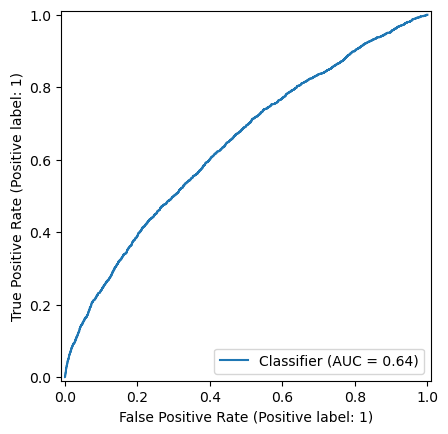

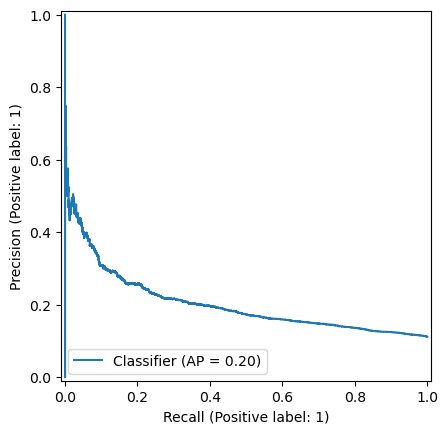

In [26]:
# ROC / PR curve
RocCurveDisplay.from_predictions(y_test, lr_proba)
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, lr_proba)
plt.show()

In [27]:
# RandomForest Model (Non-linear effects and Feature interaction) 
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", rf)
])

rf_pipe.fit(X_train, y_train)

rf_proba = rf_pipe.predict_proba(X_test)[:, 1]
print("RF ROC-AUC:", roc_auc_score(y_test, rf_proba))
print("RF PR-AUC:", average_precision_score(y_test, rf_proba))

RF ROC-AUC: 0.6623306256027267
RF PR-AUC: 0.21571665983742866


In [28]:
# Threshold tuning
def eval_at_threshold(y_true, proba, t):
    pred = (proba >= t).astype(int)
    report = classification_report(y_true, pred, output_dict=True)
    return {
        "threshold": t,
        "precision_1": report["1"]["precision"],
        "recall_1": report["1"]["recall"],
        "f1_1": report["1"]["f1-score"],
        "accuracy": report["accuracy"]
    }

rows = []
for t in [0.5, 0.4, 0.3, 0.25, 0.2, 0.15]:
    rows.append(eval_at_threshold(y_test, rf_proba, t))

pd.DataFrame(rows)

,threshold,precision_1,recall_1,f1_1,accuracy
0,0.50,0.684211,0.005724,0.011354,0.888769
1,0.40,0.660377,0.015412,0.030120,0.889260
2,0.30,0.522989,0.040070,0.074438,0.888818
3,0.25,0.375824,0.075297,0.125459,0.882873
4,0.20,0.283605,0.160722,0.205171,0.861059
5,0.15,0.212371,0.352268,0.264988,0.781959


In [29]:
# Feature importance Top 20(RF)
ohe = rf_pipe.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

all_features = np.concatenate([num_cols, cat_feature_names])
importances = rf_pipe.named_steps["model"].feature_importances_

feat_imp = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp.head(20)

,feature,importance
4,num_lab_procedures,0.051343
6,num_medications,0.047815
9,number_inpatient,0.039813
3,time_in_hospital,0.037928
1,discharge_disposition_id,0.030244
10,number_diagnoses,0.027511
5,num_procedures,0.027260
0,admission_type_id,0.020709
2,admission_source_id,0.017991
7,number_outpatient,0.013678


In [30]:
feat_imp.head(20).to_csv("../data/feature_importance_top20.csv", index=False)

In [31]:
# Test set scoring for Power BI / Fabric 
rf_scored_test = X_test.copy()
rf_scored_test["actual"] = y_test.values
rf_scored_test["risk_score"] = rf_proba

bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["0-0.2","0.2-0.4","0.4-0.6","0.6-0.8","0.8-1.0"]
rf_scored_test["risk_bin"] = pd.cut(rf_scored_test["risk_score"].astype(float),
                                    bins=bins, labels=labels, include_lowest=True)

def segment(score):
    if score >= 0.4:
        return "High"
    elif score >= 0.2:
        return "Medium"
    else:
        return "Low"

rf_scored_test["risk_segment"] = rf_scored_test["risk_score"].apply(segment)

rf_scored_test.columns = rf_scored_test.columns.str.replace("-", "_", regex=False)

rf_scored_test.to_csv("../data/hospital_risk_segmentation_test.csv", index=False)

In [32]:
# Full dataset scoring for Power BI / Fabric 
rf_proba_all = rf_pipe.predict_proba(X)[:, 1]

rf_scored_all = X.copy()
rf_scored_all["actual"] = y.values
rf_scored_all["risk_score"] = rf_proba_all
rf_scored_all["risk_bin"] = pd.cut(rf_scored_all["risk_score"].astype(float),
                                   bins=bins, labels=labels, include_lowest=True)
rf_scored_all["risk_segment"] = rf_scored_all["risk_score"].apply(segment)
rf_scored_all.columns = rf_scored_all.columns.str.replace("-", "_", regex=False)

rf_scored_all.to_csv("../data/hospital_risk_segmentation_all.csv", index=False)

## Modeling Summary

- Two models were evaluated: Logistic Regression (baseline) and Random Forest (nonlinear ensemble).
- Random Forest slightly outperformed Logistic Regression in both ROC-AUC (0.662 vs. 0.642) and PR-AUC (0.216 vs. 0.203), indicating improved discrimination and better handling of class imbalance. However, overall performance suggests moderate predictive capacity rather than strong separation.
- Given the class imbalance, threshold analysis was conducted to assess the operational trade-off between precision and recall.
- At the default threshold of 0.5, recall was extremely low (0.6%), indicating that most high-risk patients would not be identified.
- Lowering the threshold improved recall substantially:
  - At 0.30 → Recall 4.0%
  - At 0.25 → Recall 7.5%
  - At 0.20 → Recall 16.1%
  - At 0.15 → Recall 35.2%
- However, recall improvements came at the expense of precision and overall accuracy.
- These findings highlight the importance of threshold selection based on operational capacity and intervention strategy, rather than relying solely on default classification thresholds.
- Overall, results support the use of machine learning–based risk scoring as a stratification tool, while emphasizing the need for policy-driven threshold optimization.

## Top 10% Recall
**Objective**  
If we intervene only on the top 10% of patients ranked by risk score, what percentage of all readmitted patients can be covered?

In [36]:
# sort by risk_score 

# based on test set
scored = pd.DataFrame({
    "actual": y_test.values,
    "risk_score": rf_proba
})

# sort
scored = scored.sort_values("risk_score", ascending=False).reset_index(drop=True)

scored.head()


,actual,risk_score
0,1,0.660000
1,0,0.653333
2,0,0.613333
3,1,0.596667
4,1,0.573333


In [37]:
#  extract top 10% 
top_10_percent_cutoff = int(len(scored) * 0.10)
top_10 = scored.iloc[:top_10_percent_cutoff]

top_10.head()

,actual,risk_score
0,1,0.660000
1,0,0.653333
2,0,0.613333
3,1,0.596667
4,1,0.573333


In [38]:
# Recall@10%

total_readmitted = scored["actual"].sum()
readmitted_in_top10 = top_10["actual"].sum()

recall_at_10 = readmitted_in_top10 / total_readmitted

print("Total readmitted:", total_readmitted)
print("Readmitted captured in top 10%:", readmitted_in_top10)
print("Recall@Top10%:", recall_at_10)

Total readmitted: 2271
Readmitted captured in top 10%: 516
Recall@Top10%: 0.22721268163804492


## What this means

If Recall at Top 10% = 0.23,  
it means that by intervening on only the top 10% of highest-risk patients, we can proactively identify 23% of all readmitted patients.  
  
This metric is far more intuitive and practical for real-world decision-making than a binary threshold.  

In [40]:
# Top 5% / 10% / 15% / 20%
for pct in [0.05, 0.10, 0.15, 0.20]:
    cutoff = int(len(scored) * pct)
    subset = scored.iloc[:cutoff]
    recall_k = subset["actual"].sum() / total_readmitted
    print(f"Recall@Top{int(pct*100)}%:", round(recall_k, 4))

Recall@Top5%: 0.1295
Recall@Top10%: 0.2272
Recall@Top15%: 0.3069
Recall@Top20%: 0.3721


## Risk Stratification Performance
When evaluated as a ranking-based stratification tool, the model demonstrates meaningful operational value. The top 10% highest-risk patients account for 22.7% of all 30-day readmissions. Expanding intervention to the top 20% increases capture to 37.2% of readmissions. This suggests that risk-based prioritization can substantially improve targeting efficiency compared to random selection.

## Intervention Simulation (Cost Savings Modeling)

### Key Question
Is a risk-based intervention economically meaningful in practice?

#### Step 1 — Simulation Assumptions
We start by setting realistic and conservative assumptions, commonly used in readmission studies:  
Average cost of a readmission: 15,000 dollars  
Cost of intervention (case manager, follow-up calls, etc.): 200 dollars per patient  
Intervention success rate (prevented readmissions): 20%  
These assumptions are intentionally conservative.  

- In Québec, most inpatient care is covered by the public health insurance (RAMQ), and while specific cost estimates for readmission are not readily available, studies have shown that a significant proportion of discharged patients return to hospital or emergency services within 30 days, suggesting a meaningful system cost impact.
- Therefore, I found the below information about the annual cost of hospital readmissions in Canada. 
- According to the Canadian Institute for Health Information (CIHI), the **annual cost of hospital readmissions in Canada** is approximately **$2.9 billion CAD**, and this estimate applies primarily to acute care settings rather than including physician fees or other components of care. In addition, recent provincial data indicate that the **risk-adjusted hospital readmission rate** across Canadian provinces and territories is around **9.7% for the 2024–2025** fiscal year. This risk-adjusted rate accounts for differences in patient characteristics and allows for fairer comparisons across regions. Together, these figures highlight both the substantial economic burden of hospital readmissions and the prevalence of re-admissions within 30 days, underscoring the value of predictive modeling and targeted interventions to reduce avoidable readmissions and associated costs.

#### Simulation Assumptions
We start by setting realistic and conservative assumptions commonly used in readmission studies.   
These values are used solely for simulation purposes at the patient level, to estimate the potential economic impact of a targeted intervention strategy.  
- Average cost of a readmission: 15,000 dollars  
- Cost of intervention (case manager, follow-up calls, etc.): 200 dollars per patient  
- Intervention success rate (prevented readmissions): 20%  
  - A 20% reduction does not mean eliminating 20% of all admissions. It means reducing a fraction of avoidable readmissions among a targeted high-risk subgroup.

#### Context: Readmissions in Québec and Canada
In Québec, most inpatient care is covered by the public health insurance system (RAMQ).  
While patient-level cost estimates for hospital readmissions are not publicly available, multiple studies indicate that a substantial proportion of discharged patients return to hospital or emergency services within 30 days, implying a significant system-wide cost burden.  
  
At the national level, the Canadian Institute for Health Information (CIHI) estimates that hospital readmissions cost approximately \$2.9 billion CAD annually.   
This figure primarily reflects acute care hospital costs and excludes physician fees and other downstream components of care.  
  
Furthermore, recent provincial data show that the risk-adjusted hospital readmission rate across Canadian provinces and territories is approximately 9.7% for the 2024–2025 fiscal year.   
This rate accounts for differences in patient characteristics and enables more meaningful comparisons across regions.  
  
Together, these figures highlight the substantial economic burden of hospital readmissions in Canada and underscore the potential value of predictive modeling and targeted, risk-based interventions to reduce avoidable readmissions.  

In [84]:
# ===== Assumptions =====
readmission_cost = 15000
intervention_cost = 200
intervention_success_rate = 0.20  # 20%

# ===== Data from test set =====
total_patients = len(scored)
total_readmissions = scored["actual"].sum()

top10_size = int(total_patients * 0.10)
top10_readmissions = scored.iloc[:top10_size]["actual"].sum()

# ===== Expected prevented readmissions =====
prevented_readmissions = top10_readmissions * intervention_success_rate

# ===== Financial calculations =====
cost_of_intervention = top10_size * intervention_cost
cost_saved = prevented_readmissions * readmission_cost

net_savings = cost_saved - cost_of_intervention

print("Total patients:", total_patients)
print("Total readmissions:", total_readmissions)
print("Top 10% patients:", top10_size)
print("Readmissions in Top 10%:", top10_readmissions)
print("Expected prevented readmissions:", round(prevented_readmissions,2))
print("Cost of intervention: $", round(cost_of_intervention,2))
print("Cost saved: $", round(cost_saved,2))
print("Net savings: $", round(net_savings,2))

Total patients: 20354
Total readmissions: 2271
Top 10% patients: 2035
Readmissions in Top 10%: 516
Expected prevented readmissions: 103.2
Cost of intervention: $ 407000
Cost saved: $ 1548000.0
Net savings: $ 1141000.0


Under conservative assumptions (20% intervention success rate and $200 per patient intervention cost), targeting the top 10% highest-risk patients yields substantial projected cost savings. This demonstrates that even moderately predictive models can generate operational value when deployed as prioritization tools.

## Why This Matters for CHUM
- Hospital readmissions represent both a clinical quality challenge and a significant operational burden. Even with moderate predictive performance (ROC-AUC ≈ 0.66), the model demonstrates meaningful value when deployed as a risk-based prioritization tool rather than a strict binary classifier.
- By targeting only the top 10% highest-risk patients, approximately 23% of 30-day readmissions can be identified in advance. Under conservative assumptions (20% intervention success rate and 200 dollars per patient intervention cost), this strategy could prevent an estimated 103 readmissions within the evaluated population, yielding projected net savings of approximately $1.14 million.
- For CHUM, this implies:
  - Improved allocation of case management and transitional care resources
  - Reduction in avoidable readmissions and associated bed occupancy
  - Enhanced quality-of-care metrics and institutional performance indicators
  - Financial sustainability through targeted, data-driven intervention strategies

- Importantly, this approach does not require perfect prediction accuracy. Instead, it leverages risk stratification to optimize limited clinical resources, aligning operational capacity with patients most likely to benefit from intervention.
- This framework supports CHUM’s strategic objective of promoting data-driven decision-making while strengthening post-discharge care coordination and reducing preventable hospital utilization.